# 制約ベースの手法（constraint based learning)

条件付き独立性のパターンから、DAGの構造（因果構造）を推定（学習）する手法群。  
独立性／非独立性の "制約 (constraints)" を満たすDAGを探すため、constraint-based と呼ばれる。

代表例がPCアルゴリズム

## PCアルゴリズム

Peter-Clark (PC) algorithm

**Step1：すべてのノード間が無向のエッジで結ばれたグラフを作る**

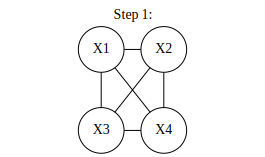

In [9]:
import graphviz

graphviz.Source("""
graph step1 {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  X1 -- X2;
  X1 -- X3;
  X1 -- X4;
  X2 -- X3;
  X2 -- X4;
  X3 -- X4;

  label="Step 1: 初期状態（完全無向グラフ）";
  labelloc="t";
  
  { rank = same; X1; X2; }
  { rank = same; X3; X4; }
}
""")

**Step 2：条件付き独立性を検定し、不要なエッジの削除**

独立性や条件付き独立性をカイ二乗検定で判定していく。 $X_i \perp X_j$ または $X_i \perp X_j \mid S$ が統計的に判定できた場合、そのエッジを削除し、分離集合（separating set）$S$ を記録する。

例：$X_1 \perp X_3 \mid X_2$ が成立 → 辺 X1–X3 を削除、sep(X1,X3) = {X2}

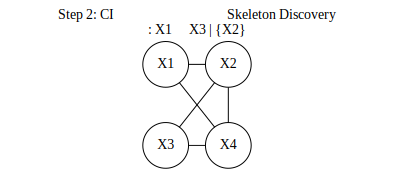

In [10]:
import graphviz

graphviz.Source("""
graph step2 {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  // Edges after removal of X1--X3
  X1 -- X2;
  X1 -- X4;
  X2 -- X3;
  X2 -- X4;
  X3 -- X4;

  label="Step 2: CI に基づくエッジ削除（Skeleton Discovery）\n例: X1 ⟂ X3 | {X2}";
  labelloc="t";
  
  { rank = same; X1; X2; }
  { rank = same; X3; X4; }
}
""")

**Step 3：V－構造（Collider）の同定**

3変数 $X_i - X_j - X_k$ のパターンで、

- $X_i$ と $X_k$ が「隣接していない」（エッジがない、$X_i \perp X_k \mid S$）
- その分離集合 sep($X_i, X_k$) に $X_j$ が含まれない（$X_j \notin S$）

のとき、$X_i \rightarrow X_j \leftarrow X_k$（V構造、collider） と向きを付ける。


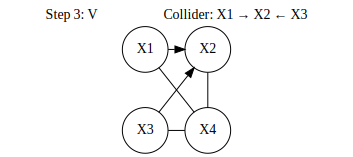

In [12]:
import graphviz

graphviz.Source("""
digraph step3 {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  X1 -> X2;
  X3 -> X2;

  // Keep the remaining undirected edges
  X1 -> X4 [dir=none];
  X2 -> X4 [dir=none];
  X3 -> X4 [dir=none];

  label="Step 3: V構造の同定（Collider: X1 → X2 ← X3）";
  labelloc="t";

  { rank = same; X1; X2; }
  { rank = same; X3; X4; }
}
""")

**Step 4：向き付け規則（Orientation Rules）で残りの辺を決める**

追加のルールを適用し、サイクルを作らない・新たな collider を作らないように残りの無向辺に向きを付ける。

代表的ルール：
- Orientation propagation：$X \to Y - Z$ なら $Y \to Z$
- Acyclicity constraint（サイクル禁止）
- Avoid new colliders（既存以外の新規 collider を作らない）


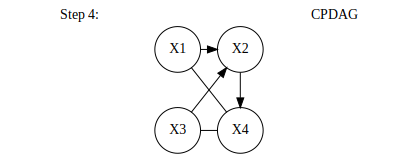

In [13]:
import graphviz

graphviz.Source("""
digraph step3 {
  rankdir=TB;
  node [shape=circle, fontsize=14];

  X1 -> X2;
  X3 -> X2;
  X2 -> X4;
  X1 -> X4 [dir=none];
  X3 -> X4 [dir=none];

  label="Step 4: 向き付け規則により部分的に方向が決定（CPDAG）";
  labelloc="t";

  { rank = same; X1; X2; }
  { rank = same; X3; X4; }
}
""")

### 実装

pgmpyパッケージに実装されている

[PC (Constraint-Based Estimator) — 1.0.0 | pgmpy docs](https://pgmpy.org/structure_estimator/pc.html)

In [1]:
from pgmpy.utils import get_example_model

# Load a Discrete Bayesian Network and simulate data.
discrete_bn = get_example_model('alarm')
alarm_df = discrete_bn.simulate(n_samples=100)

# Learn a network from simulated data.
from pgmpy.estimators import PC
dag = PC(data=alarm_df).estimate(ci_test='chi_square', return_type='dag')

# Learn the parameters from the data.
dag_fitted = dag.fit(alarm_df)
dag_fitted.get_cpds()

INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 16.
INFO:numexpr.utils:NumExpr defaulting to 16 threads.


  0%|          | 0/37 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HRBP': 'C', 'INSUFFANESTH': 'C', 'ANAPHYLAXIS': 'C', 'PVSAT': 'C', 'PCWP': 'C', 'SHUNT': 'C', 'PAP': 'C', 'EXPCO2': 'C', 'BP': 'C', 'HRSAT': 'C', 'CO': 'C', 'DISCONNECT': 'C', 'ERRCAUTER': 'C', 'KINKEDTUBE': 'C', 'MINVOL': 'C', 'PULMEMBOLUS': 'C', 'INTUBATION': 'C', 'ERRLOWOUTPUT': 'C', 'HISTORY': 'C', 'FIO2': 'C', 'STROKEVOLUME': 'C', 'CVP': 'C', 'MINVOLSET': 'C', 'HYPOVOLEMIA': 'C', 'LVFAILURE': 'C', 'CATECHOL': 'C', 'ARTCO2': 'C', 'VENTALV': 'C', 'LVEDVOLUME': 'C', 'SAO2': 'C', 'VENTMACH': 'C', 'HREKG': 'C', 'VENTTUBE': 'C', 'PRESS': 'C', 'TPR': 'C', 'VENTLUNG': 'C', 'HR': 'C'}


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'HRBP': 'C', 'INSUFFANESTH': 'C', 'ANAPHYLAXIS': 'C', 'PVSAT': 'C', 'PCWP': 'C', 'SHUNT': 'C', 'PAP': 'C', 'EXPCO2': 'C', 'BP': 'C', 'HRSAT': 'C', 'CO': 'C', 'DISCONNECT': 'C', 'ERRCAUTER': 'C', 'KINKEDTUBE': 'C', 'MINVOL': 'C', 'PULMEMBOLUS': 'C', 'INTUBATION': 'C', 'ERRLOWOUTPUT': 'C', 'HISTORY': 'C', 'FIO2': 'C', 'STROKEVOLUME': 'C', 'CVP': 'C', 'MINVOLSET': 'C', 'HYPOVOLEMIA': 'C', 'LVFAILURE': 'C', 'CATECHOL': 'C', 'ARTCO2': 'C', 'VENTALV': 'C', 'LVEDVOLUME': 'C', 'SAO2': 'C', 'VENTMACH': 'C', 'HREKG': 'C', 'VENTTUBE': 'C', 'PRESS': 'C', 'TPR': 'C', 'VENTLUNG': 'C', 'HR': 'C'}


[<TabularCPD representing P(DISCONNECT:2) at 0x7b37b5778040>,
 <TabularCPD representing P(VENTTUBE:3 | DISCONNECT:2, VENTMACH:4) at 0x7b37b57eb1c0>,
 <TabularCPD representing P(HR:3) at 0x7b37b57ebd60>,
 <TabularCPD representing P(HRBP:3 | ERRLOWOUTPUT:2, HR:3) at 0x7b37b57ea7d0>,
 <TabularCPD representing P(HREKG:3 | HR:3, HRSAT:3) at 0x7b37b57e8160>,
 <TabularCPD representing P(ANAPHYLAXIS:2) at 0x7b37b57eb220>,
 <TabularCPD representing P(EXPCO2:4 | ANAPHYLAXIS:2, VENTLUNG:4) at 0x7b37b57e9090>,
 <TabularCPD representing P(VENTLUNG:4) at 0x7b37b57ea140>,
 <TabularCPD representing P(HRSAT:3) at 0x7b37b57e9a20>,
 <TabularCPD representing P(VENTMACH:4) at 0x7b37b57e80d0>,
 <TabularCPD representing P(ERRLOWOUTPUT:2) at 0x7b37b57e9d20>,
 <TabularCPD representing P(KINKEDTUBE:2) at 0x7b37b57eb670>,
 <TabularCPD representing P(PRESS:4 | KINKEDTUBE:2) at 0x7b37b5465540>,
 <TabularCPD representing P(SAO2:3) at 0x7b37b5467460>,
 <TabularCPD representing P(PVSAT:3 | SAO2:3) at 0x7b37b5467130>,